# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MultipleLocator
import scipy.linalg as sl

## GW150914

Download data

In [3]:
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

Set some parameters of GW150914

In [4]:
input = dict(model_list = [(2, 2, 0, 'p')], #l, m, n, prograde/retrograde
             # trucation time (geocenter, in second)
             t_init = 1126259462.4083147+2.0*1e-3,
             # length of the analysis segment (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [5]:
fit.import_ligo_data('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5')
fit.import_ligo_data('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5')

Perform time alignment across detectors

In [6]:
fit.detector_alignment()

Condition data 

In [7]:
fit.condition_data('original_data', **input)

Cholesky-decomposition of the covariance matrix 

In [8]:
fit.compute_acfs('original_data')
fit.cholesky_decomposition()
fit.first_index()

In [13]:
delta_mass = 1.0
delta_chi = 0.02
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [39]:
import astropy.constants as c
import qnm
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3
class Filter_Arr:
    """Container for rational filters.

    Attributes
    ----------
    chi : float
        remnant dimensionless spin.
    mass : float
        remnant mass, in solar mass.
    model_list : a list of dictionaries
        quasinormal modes to be filtered.
    """

    def __init__(self, chi=None, mass=None, model_list=None):
        """Constructor"""
        self.chi = chi
        self.mass = mass  # in solar mass

        self.model_list = []
        if model_list != None:
            for l, m, n, p in model_list:
                self.model_list.append(dict(l=l, m=m, n=n, p=p))

    @property
    def get_freq_list(self) -> list:
        """Return a list of QNM frequencies stored in :attr:`Filter.model_list`."""
        freq_list = {}
        for mode in self.model_list:
            this_l = mode["l"]
            this_m = mode["m"]
            this_n = mode["n"]
            this_p = mode["p"]
            omega = qnm.modes_cache(s=-2, l=this_l, m=this_m, n=this_n)(a=self.chi)[0]
            if this_p == "p":
                freq_list[str(this_l) + str(this_m) + str(this_n)] = omega
            elif this_p == "r":
                freq_list[str(this_l) + str(this_m) + str(this_n)] = -np.conj(omega)
        return freq_list

    @property
    def get_spin(self) -> float:
        """Return :attr:`Filter.chi`."""
        return self.chi

    @property
    def get_mass(self) -> float:
        """Return :attr:`Filter.mass`."""
        return self.mass

    @property
    def get_model_list(self) -> list[dict]:
        """Return :attr:`Filter.model_list`."""
        return self.model_list

    @staticmethod
    def mass_unit(mass) -> float:
        """Convert mass unit from solar mass to second."""
        return mass * T_MSUN

    def pos_filter(self, normalized_freq, l, m, n):
        r"""The positive rational filter:

        .. math::
            \frac{\omega-\omega_{lmn}}{\omega-\omega_{lmn}^*}

        Parameters
        ----------
        normalized_freq : array
            in remnant mass, frequencies that rational filters are evaluated at.
        l : int
            angular index
        m : int
            angular index
        n : int
            overtone index

        Returns
        -------
        array
        """
        omega = np.array([qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=i)[0] for i in chi_arr])
        return (normalized_freq - omega) / (normalized_freq - np.conj(omega))

    def neg_filter(self, normalized_freq, l, m, n):
        r"""The negative rational filter:

        .. math::
            \frac{\omega+\omega_{lmn}^*}{\omega+\omega_{lmn}}

        Parameters
        ----------
        normalized_freq : array
            in remnant mass, frequencies that rational filters are evaluated at.
        l : int
            angular index
        m : int
            angular index
        n : int
            overtone index

        Returns
        -------
        array
        """
        omega = np.array([qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=i)[0] for i in chi_arr])
        return (normalized_freq + np.conj(omega)) / (normalized_freq + omega)

    def single_filter(self, normalized_freq, l, m, n):
        r"""A combination of the negative and postive rational filters

        .. math::
            \frac{\omega-\omega_{lmn}}{\omega-\omega_{lmn}^*}\frac{\omega+\omega_{lmn}^*}{\omega+\omega_{lmn}}

        Parameters
        ----------
        normalized_freq : array
            in remnant mass, frequencies that rational filters are evaluated at.
        l : int
            angular index
        m : int
            angular index
        n : int
            overtone index

        Returns
        -------
        array
        """
        return self.neg_filter(normalized_freq, l, m, n) * self.pos_filter(
            normalized_freq, l, m, n
        )

    def NR_filter(self, freq):
        """Rational filters for numerical-relativity waveforms, removing the modes stored in :attr:`Filter.model_list`.

        Parameters
        ----------
        freq : array
            the unit should be the same as :attr:`Filter.mass`

        Raises
        ------
        ValueError
            When :attr:`Filter.mass` or :attr:`Filter.chi` is not provided
        """
        final_rational_filter = 1
        if not bool(self.model_list):
            return final_rational_filter
        else:
            if (self.mass is None) or (self.chi is None):
                raise ValueError(
                    f"Mass = {self.mass}" f" and Spin = {self.chi} are needed"
                )
        normalized_freq = freq * self.mass
        for mode in self.model_list:
            if mode["p"] == "p":
                final_rational_filter *= self.pos_filter(
                    normalized_freq, mode["l"], mode["m"], mode["n"]
                )
            elif mode["p"] == "r":
                final_rational_filter *= self.neg_filter(
                    normalized_freq, mode["l"], mode["m"], mode["n"]
                )
        return final_rational_filter

    def total_filter(self, freq):
        """The total rational filter that removes the modes stored in :attr:`Filter.model_list`.

        Parameters
        ----------
        freq : array
            in Hz, frequencies that the total filter is evaluated at.
        """
        final_rational_filter = 1
        if not bool(self.model_list):
            return final_rational_filter
        else:
            if (self.mass is None) or (self.chi is None):
                raise ValueError(
                    f"Mass = {self.mass}" f" and Spin = {self.chi} are needed"
                )
        normalized_freq = np.outer(freq,self.mass) * T_MSUN
        for mode in self.model_list:
            final_rational_filter *= self.single_filter(
                -normalized_freq, mode["l"], mode["m"], mode["n"]
            )
        return final_rational_filter

In [41]:
test = Filter_Arr(mass=mass_arr, chi=chi_arr, model_list=model_list).total_filter(fft_freqs)

In [50]:
mass_arr = mass_grid.flatten()
chi_arr = chi_grid.flatten()
model_list = [(2,2,0,'p')]
likelihood_arr = np.zeros(len(mass_arr))


# Need to check length of original data and time interval is same for all ifos
fft_freqs = np.fft.rfftfreq(len(fit.original_data['H1']), d=fit.original_data['H1'].time_interval) * 2 * np.pi
filter_arr = Filter_Arr(mass=mass_arr, chi=chi_arr, model_list=model_list).total_filter(fft_freqs).T

for ifo, data in fit.original_data.items():
    length = len(data)
    data_arr = np.broadcast_to(data.values, (len(mass_arr), length))
    freq_amps_arr = np.fft.rfft(data_arr, axis=1, norm='ortho')
    ifft = np.fft.irfft(
        freq_amps_arr*filter_arr, norm="ortho", n=length, axis=1
    )
    truncated = ifft[:,fit.i0_dict[ifo]:fit.i0_dict[ifo]+fit.sampling_n]
    wd_arr = sl.cho_solve((fit.cholesky_L[ifo], True), truncated.T)
    temp = -0.5*np.sum(wd_arr.T * truncated, axis=1)
    likelihood_arr += temp

In [51]:
likelihood_data = np.reshape(likelihood_arr, np.shape(mass_grid))
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [53]:
def test():
    mass_arr = mass_grid.flatten()
    chi_arr = chi_grid.flatten()
    model_list = [(2,2,0,'p')]
    likelihood_arr = np.zeros(len(mass_arr))
    fft_freqs = np.fft.rfftfreq(len(fit.original_data['H1']), d=fit.original_data['H1'].time_interval) * 2 * np.pi
    filter_arr = Filter_Arr(mass=mass_arr, chi=chi_arr, model_list=model_list).total_filter(fft_freqs).T

    for ifo, data in fit.original_data.items():
        length = len(data)
        data_arr = np.broadcast_to(data.values, (len(mass_arr), length))
        freq_amps_arr = np.fft.rfft(data_arr, axis=1, norm='ortho')
        ifft = np.fft.irfft(
            freq_amps_arr*filter_arr, norm="ortho", n=length, axis=1
        )
        truncated = ifft[:,fit.i0_dict[ifo]:fit.i0_dict[ifo]+fit.sampling_n]
        wd_arr = sl.cho_solve((fit.cholesky_L[ifo], True), truncated.T)
        temp = -0.5*np.sum(wd_arr.T * truncated, axis=1)
        likelihood_arr += temp
    return likelihood_arr

In [55]:
likelihood_arr = test()
likelihood_data = np.reshape(likelihood_arr, np.shape(mass_grid))
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [57]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [58]:
%lprun -f test test()

Text(0, 0.5, '$\\chi_f$')

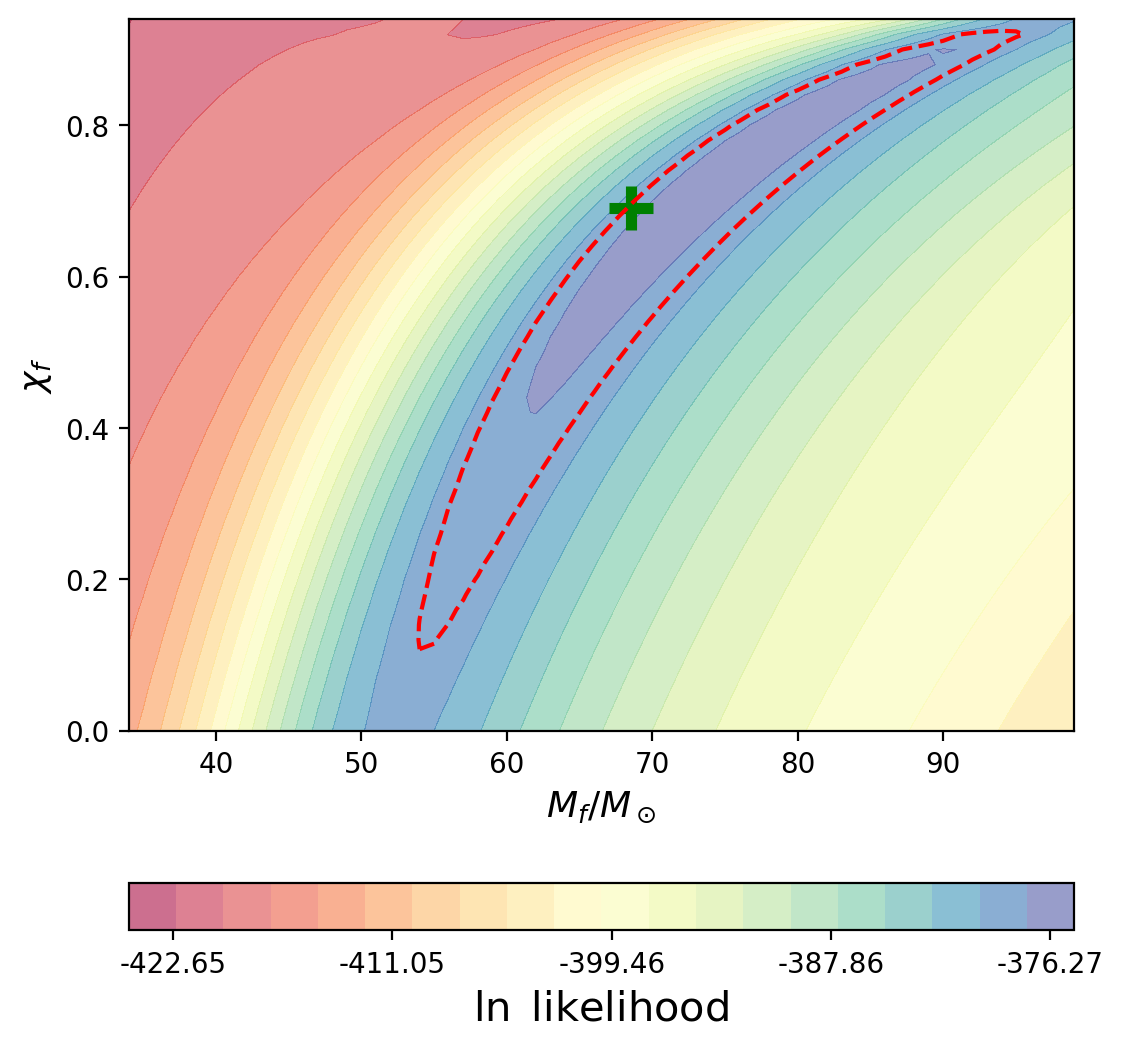

In [56]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

In [213]:
ifo = 'L1'
data = fit.original_data[ifo]
idx = 0
length = len(data)

freq_amps = np.fft.rfft(data, norm="ortho")
ifft = np.fft.irfft(
    freq_amps*filter_arr[idx], norm="ortho", n=length
)
truncated = ifft[fit.i0_dict[ifo]:fit.i0_dict[ifo]+fit.sampling_n]
a = sl.cho_solve((fit.cholesky_L[ifo], True), truncated)
temp = -0.5*np.dot(a, truncated)

## Likelihood as a function of mass and spin

Sampling remnant mass and spin

In [10]:
delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Interate over the samplings

In [59]:
fit.first_index()
likelihood_data, _ = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 10, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [12]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

Plot 2d contours

Text(0, 0.5, '$\\chi_f$')

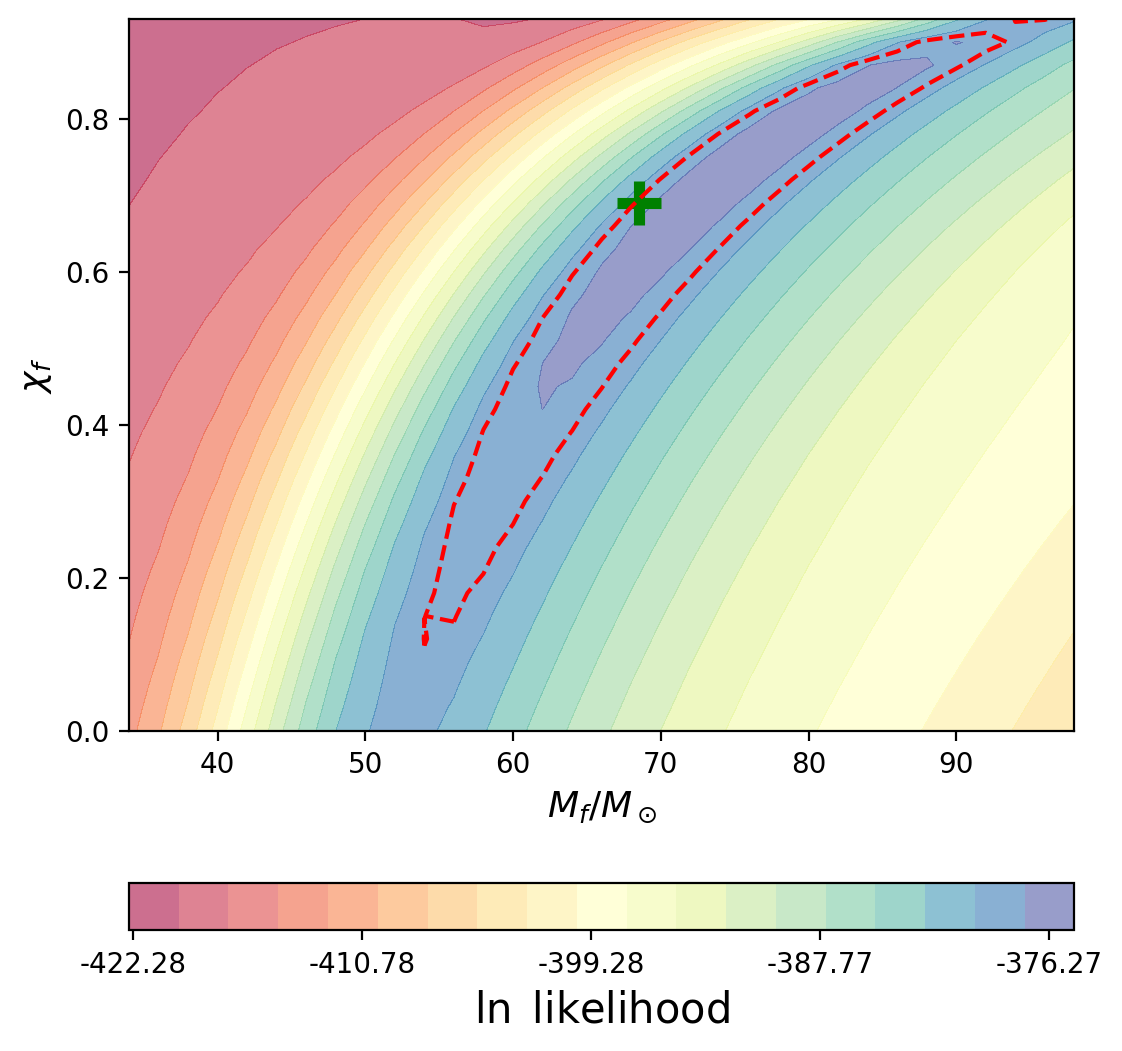

In [13]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

In [20]:
import sys
mb_size = sys.getsizeof(fit.original_data['H1'])/1024**2
print("%.3fMB" % (mb_size))

0.500MB


With 1D side plots

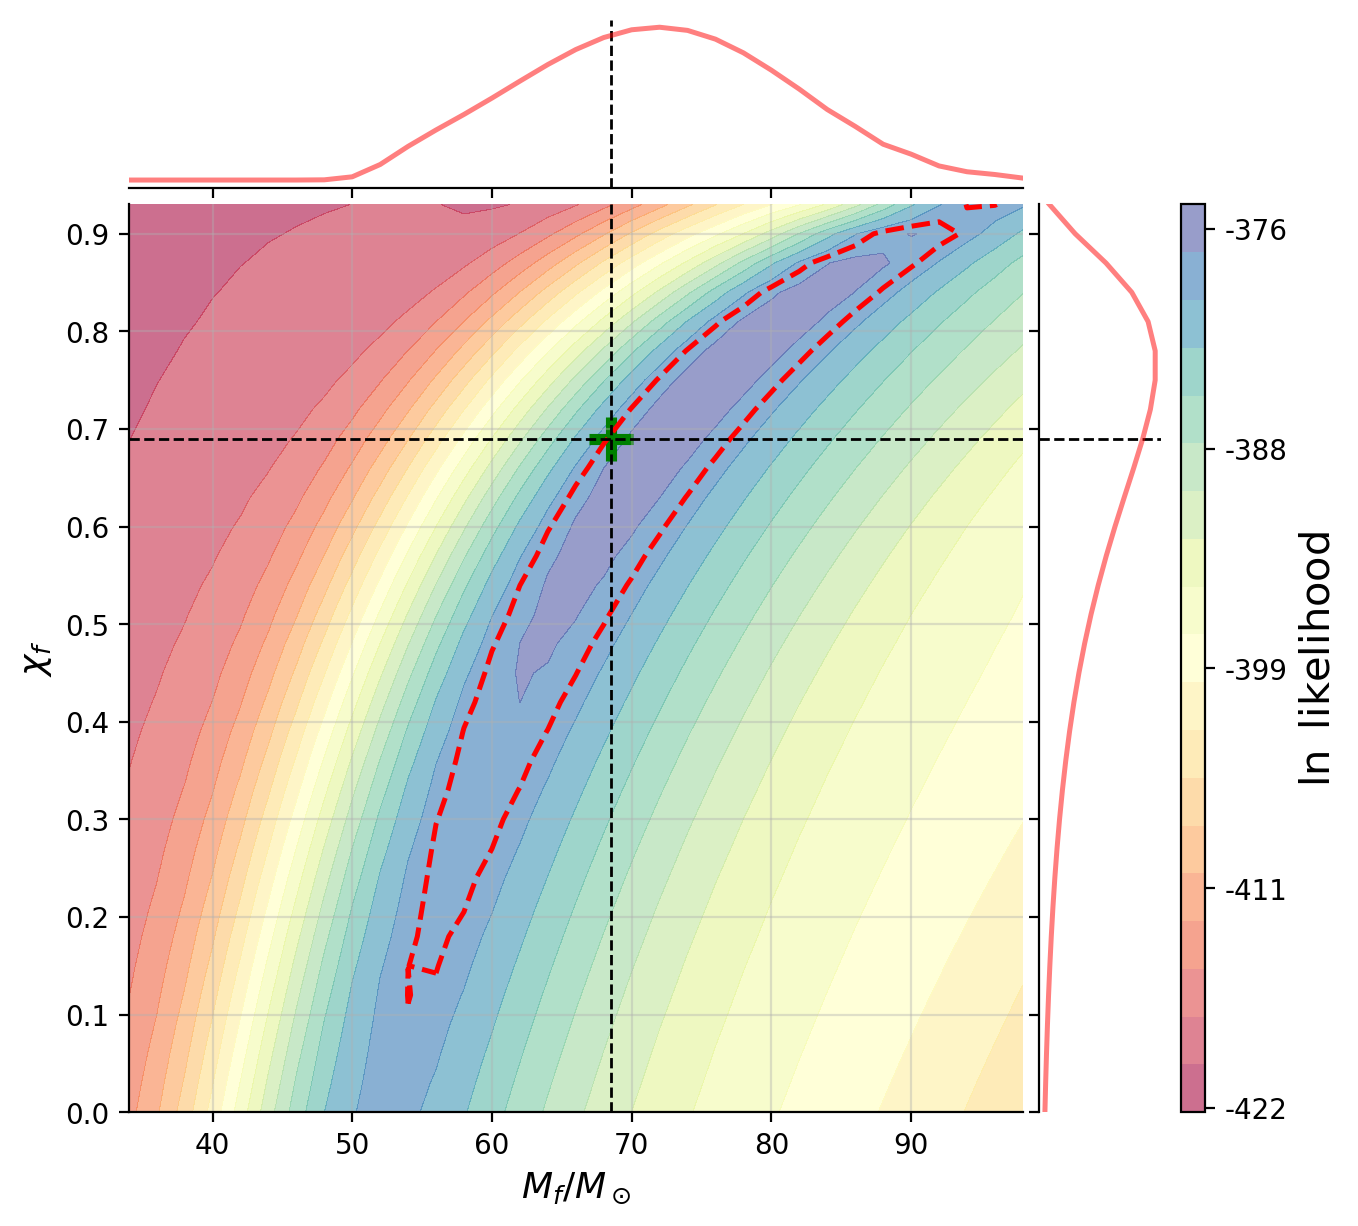

In [13]:
g = sns.JointGrid(ratio=5,space=0.1)

# 2D
contours=g.ax_joint.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
g.ax_joint.contour(contours, levels=[credible_region], linewidths=1.8,
                   linestyles='--', colors='red')
g.ax_joint.xaxis.set_major_locator(MultipleLocator(10))
g.ax_joint.yaxis.set_major_locator(MultipleLocator(0.1))
g.ax_joint.scatter(x=68.5, y=0.69, s=255, marker='+', 
                   c='g', linewidths=4, label='IMR')
g.ax_joint.axvline(68.5, ls='--', lw=1, c='k')
g.ax_joint.axhline(0.69, ls='--', lw=1, c='k')
g.ax_joint.set_xlabel(r'$M_f/M_\odot$', fontsize=13)
g.ax_joint.set_ylabel(r'$\chi_f$', fontsize=13)
g.ax_joint.grid(alpha=0.4)

# 1D side plots 
g.ax_marg_x.axvline(68.5, ls='--', lw=1, c='k')
g.ax_marg_x.plot(massspace, projected_mass, color='r', lw=1.8, alpha=0.5)

g.ax_marg_y.axhline(0.69, ls='--', lw=1, c='k')
g.ax_marg_y.plot(projected_chi, chispace, color='r',lw=1.8,alpha=0.5)

# coloarbar
divider = make_axes_locatable(g.ax_marg_y)
cax = divider.append_axes('right', size='20%', pad=0.1)
cbar=g.fig.colorbar(contours, cax=cax, orientation="vertical", format='%3.0f', ax=g.ax_marg_y)
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))